In [ ]:
pip install alpaca_trade_api

In [ ]:
pip install pandas_ta

In [17]:
# Settings and preparation
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame, TimeFrameUnit
import time
import pandas as pd
from datetime import datetime, date,timedelta
import pandas_ta as ta
import numpy as np

# Set your API key and secret
api_key = 'PK9YS2AN85VR8MBYGJVK'
api_secret = 'BbjTmlOtt7aPhMgirKGEDajm9jPYceAXPQjQBBBw'
base_url = 'https://paper-api.alpaca.markets'  # Use paper trading base URL for testing

# Initialize Alpaca API
api = tradeapi.REST(api_key, api_secret, base_url, api_version='v2')

In [4]:
# initial parameters
symbol = 'SPY'  # Replace with your desired stock symbol #
interval = 5 # time intervals in seconds
start_date = "2023-06-01"
end_date = str(date.today())

In [6]:
# get historial market data
def get_historical_data(symbol,timeframe,start_date,end_date):
  historical_data = api.get_bars(symbol, timeframe, start_date, end_date, adjustment='raw').df
  return historical_data


# get latest market data
def get_latest_data(symbol, timeframe):
  latest_data =api.get_latest_bars(symbol).df
  return latest_data

In [7]:
# save data
def save_to_csv(data, filename):
  # Save the data to a CSV file
  # If the file exists, append the new data (ignoring the header)
  # If the file does not exist, write with a header
  data.to_csv(filename, mode='a', header=not pd.io.common.file_exists(filename), index=False)

In [8]:
# building technical indicators
def add_technical_indicators(df):

  # Calculate Simple Moving Average (SMA) with a window of 50 periods
  df['SMA_50'] = df['close'].rolling(window=50).mean()

  # Calculate Moving Average Convergence Divergence (MACD)
  df['MACD'] = ta.macd(df['close'])['MACD_12_26_9']

  # Calculate Relative Strength Index (RSI)
  df['RSI'] = ta.rsi(df['close'], length=14)

  # Calculate Bollinger Bands
  bollinger = ta.bbands(df['close'], length=20, std=2)
  df['BBL'] = bollinger['BBL_20_2.0']
  df['BBM'] = bollinger['BBM_20_2.0']
  df['BBU'] = bollinger['BBU_20_2.0']

  # Calculate Average True Range (ATR)
  df['ATR'] = ta.atr(df['high'], df['low'], df['close'], length=14)

  return df

In [9]:
# trading rules
def (df,letrading_strategy_BollingerBandsngth,std):
  # build bollingerbands
  bollinger = ta.bbands(df['close'], length=length, std=std)
  df['BBL'] = bollinger[f'BBL_{length}_{std}.0']
  df['BBM'] = bollinger[f'BBM_{length}_{std}.0']
  df['BBU'] = bollinger[f'BBU_{length}_{std}.0']

  buy_signal = (df['close'] < df['BBL'])  # Example condition for a Buy signal
  sell_signal = (df['close'] > df['BBU'])  # Example condition for a Sell signal

  # Assign signals
  df['signal'] = 0  # Default 'no action'
  df.loc[buy_signal, 'signal'] = 1  # Buy
  df.loc[sell_signal, 'signal'] = -1  # Sell

  return df

In [27]:
# backtesting data retrieve

start_date_bt = "2023-01-01"
end_date_bt = "2024-01-01"
timeframe = '1Min'  # Daily timeframe
df = api.get_bars(symbol, timeframe, start_date_bt, end_date_bt, adjustment='raw').df

<Axes: xlabel='timestamp'>

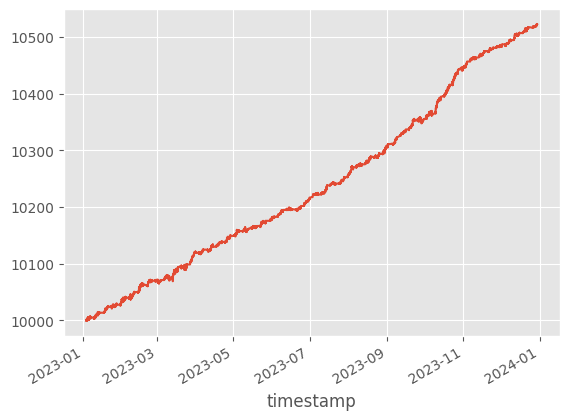

In [28]:
# backtesting and optimization

# tried different combinations of time length window and bands width
df = trading_strategy_BollingerBands(df,20,1)

# simulate strategy
initial_capital = float(10000.0)
positions = pd.DataFrame(index=df.index).fillna(0.0)
portfolio = pd.DataFrame(index=df.index).fillna(0.0)

# Assume you can buy one share per signal event
positions['stock'] = df['signal']

# Calculate the notional (or theoretical) position
portfolio['positions'] = (positions.multiply(df['close'], axis=0))

# Subtract the initial capital by the notional position to get the amount of liquid cash in the portfolio
portfolio['cash'] = initial_capital - (positions.diff().multiply(df['close'], axis=0)).cumsum()

# Get the total value of the portfolio (cash + stock value)
portfolio['total'] = portfolio['positions'] + portfolio['cash']

# Calculate the returns by taking the percentage change in the total portfolio value
portfolio['returns'] = portfolio['total'].pct_change()

# Plot the equity curve
portfolio['total'].plot()

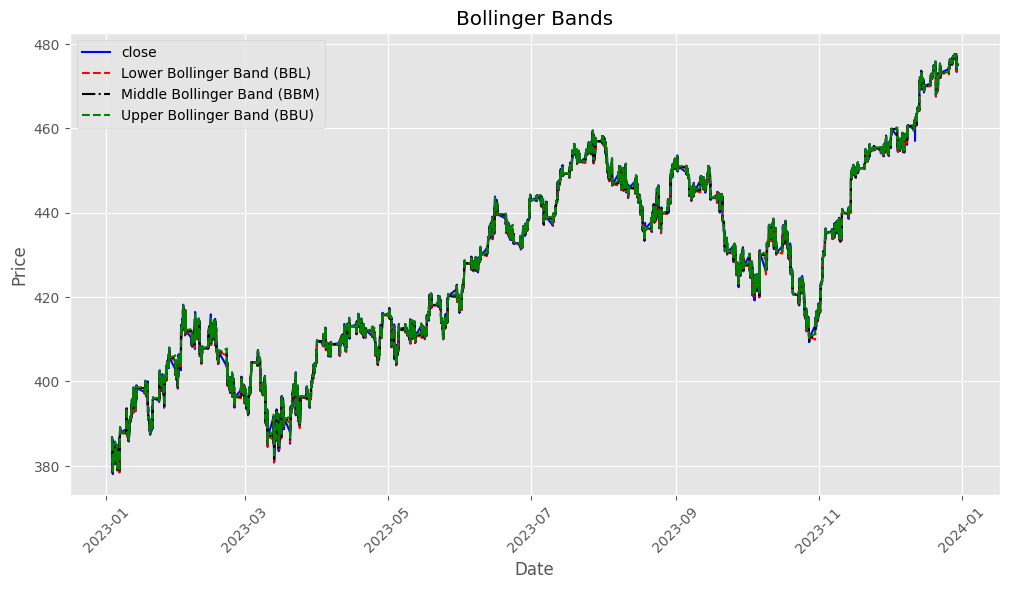

In [12]:
# visualize bollinger bands
import matplotlib.pyplot as plt

# Ensure you're using the 'ggplot' style for better visuals
plt.style.use('ggplot')

# Create a new figure and a subplot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the closing price
ax.plot(df.index, df['close'], label='close', color='blue')

# Plot the Bollinger Bands
ax.plot(df.index, df['BBL'], label='Lower Bollinger Band (BBL)', linestyle='--', color='red')
ax.plot(df.index, df['BBM'], label='Middle Bollinger Band (BBM)', linestyle='-.', color='black')
ax.plot(df.index, df['BBU'], label='Upper Bollinger Band (BBU)', linestyle='--', color='green')

# Add title and labels
ax.set_title('Bollinger Bands')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

# Rotate date labels
plt.xticks(rotation=45)

# Show legend
ax.legend()

# Show plot
plt.show()

In [ ]:
# trading system

df = pd.DataFrame(columns=['timestamp', 'close'])
position = 0
initial_capital = float(100000.0)
orders = []

while True:
  try:
    # get latest data to today
    latest_data =api.get_latest_bars(symbol)
    close_price = latest_data[symbol].close
    timestamp = latest_data[symbol].timestamp

    # save data
    if len(df)>=10000:
      filename = symbol + 'Close price' + timestamp +'.csv'
      save_to_csv(df, filename)
      df = pd.DataFrame(df.iloc[-20:,:],columns=['timestamp', 'close'])

    new_data = {'timestamp': timestamp, 'close': close_price}
    df = df.append(new_data,ignore_index=True)

    if len(df)> 20:
      # build bollingerbands and trading signals
      df = trading_strategy_BollingerBands(df,20,1)

      if df.iloc[-1,-1] == 1:

        # buy order
        api.submit_order(
            symbol = symbol,
            qty=100, # quantity adjustment
            side = 'buy',
            type = 'limit',
            time_in_force = 'gtc', # good until canceled
            limit_price = close_price * 1.01 # limit order slightely above the current price
        )
        position +=100
        orders.append([timestamp, 100, close_price])
        print("Buy order placed at {}".format(close_price))

      elif df.iloc[-1,-1] == -1:

        # sell order
        api.submit_order(
            symbol = symbol,
            qty=100, # quantity adjustment
            side = 'sell',
            type = 'limit',
            time_in_force = 'gtc', # good until canceled
            limit_price = close_price * 0.99 # limit order slightely below the current price
        )
        position -=100
        orders.append([timestamp, -100, close_price])
        print("Sell order placed at {}".format(close_price))

      # wait for the next interval
      time.sleep(interval)

  except Exception as e:
    print(f"An error occurred: {e}")

In [26]:
# monitoring

cash = initial_capital
positions = 0
#orders = [[1,100,3.41],[1,100,3.99],[1,-100,2.41]]
for _, position, price in orders:
  cash -= position*price
  positions += position

# pnl for the strategy equals cash remain plus value of stock minus initial capital
pnl_all = cash+positions*orders[-1][-1]-initial_capital

print(f"At {timestamp}, position for {symbol} is {position}. PnL is {pnl_all}.")


At 2024-02-15 15:59:00-05:00, position for SPY is -100. PnL is -258.0.
